In [1]:
%%sh
pwd

/home/lausena/developer/repos/spacecraft-pose-pose-estimation-runtime/juptyer-notebooks


In [58]:
!pip install transforms3d --quiet

In [72]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import transforms3d.quaternions as quat
from scipy import signal
import scipy.fft as sfft

In [113]:
camera_matrix = np.array([[5.2125371e+03, 0.0000000e+00, 6.4000000e+02],
                          [0.0000000e+00, 6.2550444e+03, 5.1200000e+02],
                          [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

# range 01f0f7459b,0,299.2
#01f0f7459b,1,

In [3]:
root = '/home/lausena/developer/repos/spacecraft-pose-pose-estimation-runtime/'

In [79]:
img1path = os.path.join(root, 'data/images/01f0f7459b/000.png')
img2path = os.path.join(root, 'data/images/01f0f7459b/001.png')

img1 = cv.imread(img1path, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(img2path, cv.IMREAD_GRAYSCALE)
img1full = cv.imread(img1path, cv.IMREAD_GRAYSCALE)
img2full = cv.imread(img2path, cv.IMREAD_GRAYSCALE)

In [34]:
# image 001:
# trans 7.64022827,-46.98920059,-42.21747971
# quat ,0.98997474,-0.0941886,-0.07856753,0.07003857
orig_trans = np.array([7.64022827,-46.98920059,-42.21747971])
orig_quat = np.array([0.98997474,-0.0941886,-0.07856753,0.07003857])

In [6]:
sift = cv.SIFT_create()

In [7]:
keypoints1, descriptor1 = sift.detectAndCompute(img1, None)
keypoints2, descriptor2 = sift.detectAndCompute(img2, None)

In [8]:
FLANN_INDEX_KDTREE = 1
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv.FlannBasedMatcher(indexParams, searchParams)
nNeighbors = 2

In [9]:
matches = flann.knnMatch(descriptor1, descriptor2, k=nNeighbors)

In [10]:
goodMatches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        goodMatches.append(m)

minGoodMatches = 5

In [11]:
len(goodMatches)

12

In [12]:
if len(goodMatches) > minGoodMatches:
    source_points = np.float32([keypoints1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)
    destination_points = np.float32([keypoints2[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)
    errorThreshold = 5
    M, mask = cv.findHomography(source_points, destination_points, cv.RANSAC, errorThreshold)
    matches_mask = mask.ravel().tolist()
    h,w = img1.shape
    img_border = np.float32([[0,0], [0, h-1], [w-1, h-1], [w-1,0]]).reshape(-1,1,2)
    warped_img_border = cv.perspectiveTransform(img_border, M)
    img2_poly = cv.polylines(img2, [np.int32(warped_img_border)], True, 255, 3, cv.LINE_AA)
else:
    print('Not enough good matches')

In [70]:
# Convert quaternion to rotation matrix
relative_rotation_matrix = np.eye(3)


translation = np.array([M[0, 2], M[1, 2], 0.])

print(orig_trans)
relative_rotation_matrix @ translation 


# Apply relative rotation matrix to target translation
# translated_target_translation = relative_rotation_matrix.dot(target_translation) + relative_translation


[  7.64022827 -46.98920059 -42.21747971]


array([667.57864786, 547.11170922,   0.        ])

In [120]:
M

array([[-5.68514399e-01, -6.06979830e-01,  6.67578648e+02],
       [-4.63964944e-01, -4.99800911e-01,  5.47111709e+02],
       [-8.50872826e-04, -9.10374034e-04,  1.00000000e+00]])

In [136]:
num, Rs, Ts, Ns = cv.decomposeHomographyMat(M, camera_matrix)

In [138]:
Ts

(array([[  15.57563491],
        [  17.51718366],
        [3150.84931608]]),
 array([[  -15.57563491],
        [  -17.51718366],
        [-3150.84931608]]),
 array([[  17.39479078],
        [  18.3478908 ],
        [3150.83507247]]),
 array([[  -17.39479078],
        [  -18.3478908 ],
        [-3150.83507247]]))

In [134]:
orig_trans

array([  7.64022827, -46.98920059, -42.21747971])

In [22]:
quat = Rotation.from_matrix(M).as_quat()
print(f'Quat: {[round(x, 4) for x in quat]}')
mean_absolute_error(quat, orig_quat)

Quat: [0.7734, 0.6339, 0.0036, 0.0002]


0.274147316244103

In [73]:
# OpenCV implementation
def find_rotation_cv(img_ref: np.ndarray, img_moved: np.ndarray) -> float:
    h, w = img_ref.shape[:2]
    hamming_w = signal.windows.hamming(w)
    hamming_h = signal.windows.hamming(h)
    hamming = np.outer(hamming_h, hamming_w)

    F_ref = np.log(np.abs(sfft.fftshift(sfft.fft2(img_ref * hamming))))
    F_moved = np.log(np.abs(sfft.fftshift(sfft.fft2(img_moved * hamming))))

    center_x = w // 2
    center_y = h // 2
    radius = min(center_x, center_y)

    # Define the desired size of the output polar image
    polar_width = radius
    polar_height = int(np.ceil(radius * np.pi / 2))

    # Perform the polar transformation
    F_ref_warpped = cv.warpPolar(
        F_ref, 
        (polar_width, polar_height), 
        (center_x, center_y), 
        radius, 
        cv.WARP_POLAR_LOG + cv.INTER_CUBIC + cv.WARP_FILL_OUTLIERS
    )
    F_moved_warpped = cv.warpPolar(
        F_moved, 
        (polar_width, polar_height), 
        (center_x, center_y), 
        radius, 
        cv.WARP_POLAR_LOG + cv.INTER_CUBIC + cv.WARP_FILL_OUTLIERS
    )

    ret = cv.phaseCorrelate(F_ref_warpped[:180], F_moved_warpped[:180])
    theta_shift = 360 / polar_height * -ret[0][1]
    return theta_shift

In [98]:
orig_trans

array([  7.64022827, -46.98920059, -42.21747971])

In [82]:
print(find_rotation_cv(img1, img2))
print(find_rotation_cv(img1full, img2full))

18.34194933780648
18.34194933780648


In [78]:
type(img1)

numpy.ndarray

In [91]:
dxy, _ = cv.phaseCorrelate(np.float32(img2),np.float32(img1))
print(f'dx={dxy[0]},dy={dxy[1]}')

dx=18.385260351169336,dy=-57.58455022775638


In [75]:
orig_trans

array([  7.64022827, -46.98920059, -42.21747971])

In [96]:
# Calculate rotation angle
angle_rad = np.arctan2(M[1, 0], M[0, 0])
z = np.degrees(angle_rad)

In [97]:
z

-140.78209486879433

In [94]:
angle_rad

-2.4571110833154752

In [119]:
depth = 1.
center_x, center_y = img2.shape[1] // 2, img2.shape[0] // 2
src_point_3d = np.array([[center_x, center_y, depth]], dtype=np.float32)
src_point_3d = np.array([[1,0,0]], dtype=np.float32)

dst_point_3d = np.concatenate((destination_points, np.ones((destination_points.shape[0], 1, 1), dtype=np.float32) * depth), axis=2)
translation = np.mean(dst_point_3d - src_point_3d, axis=0)
translation

array([[652.49585, 514.9872 ,   1.     ]], dtype=float32)

In [118]:
# Compute translation vector using camera intrinsic matrix
Rt = np.eye(4)  # Initialize extrinsic matrix (identity matrix for rotation and translation)
Rt[:3, 3] = translation

# Compute camera extrinsic matrix
extrinsic_matrix = camera_matrix.dot(Rt)

# # Convert 3D points to homogeneous coordinates
# src_point_3d_homogeneous = np.concatenate((src_point_3d, np.ones((src_point_3d.shape[0], 1), dtype=np.float32)), axis=1)
# dst_point_3d_homogeneous = np.concatenate((dst_point_3d, np.ones((dst_point_3d.shape[0], 1), dtype=np.float32)), axis=1)

# # Compute normalized coordinates
# src_point_normalized = cv2.convertPointsToHomogeneous(cv2.undistortPoints(src_point_3d_homogeneous, camera_matrix, None))
# dst_point_normalized = cv2.convertPointsToHomogeneous(cv2.undistortPoints(dst_point_3d_homogeneous, camera_matrix, None))

# # Compute translation vector
# translation = np.mean(dst_point_normalized - src_point_normalized, axis=0)

# # Output translation
# print("Translation (x, y, z):", translation)


ValueError: shapes (3,3) and (4,4) not aligned: 3 (dim 1) != 4 (dim 0)

In [23]:
detector = cv.ORB_create()

In [29]:
# Detect keypoints and compute descriptors
keypoints1, descriptors1 = detector.detectAndCompute(img1, None)
keypoints2, descriptors2 = detector.detectAndCompute(img2, None)

# Match keypoints between the two images
matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = matcher.match(descriptors1, descriptors2)

# Extract matched keypoints
points1 = np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

# Estimate transformation
TransM, _ = cv.estimateAffinePartial2D(points1, points2)

array([[   1.01323827,    0.35591427, -163.99381348],
       [  -0.35591427,    1.01323827,  214.32536429]])

In [ ]:
# result_image = cv.drawMatches(img1, keypoints1, img2, keypoints2, matches[:10], None)
# cv.imshow('Matches', result_image)
# cv.waitKey(0)
# cv.destroyAllWindows()

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


In [169]:
attributes = dir(goodMatches[0])
public_attributes = [attr for attr in attributes if not attr.startswith('_')]
public_attributes

['distance', 'imgIdx', 'queryIdx', 'trainIdx']

In [170]:
green = (0, 255, 0)
drawParams = dict(matchColor=green, singlePointColor=None, matchesMask=matches_mask, flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
imgMatch = cv.drawMatches(img1, keypoints1, img2_poly, keypoints2, goodMatches, None, **drawParams)

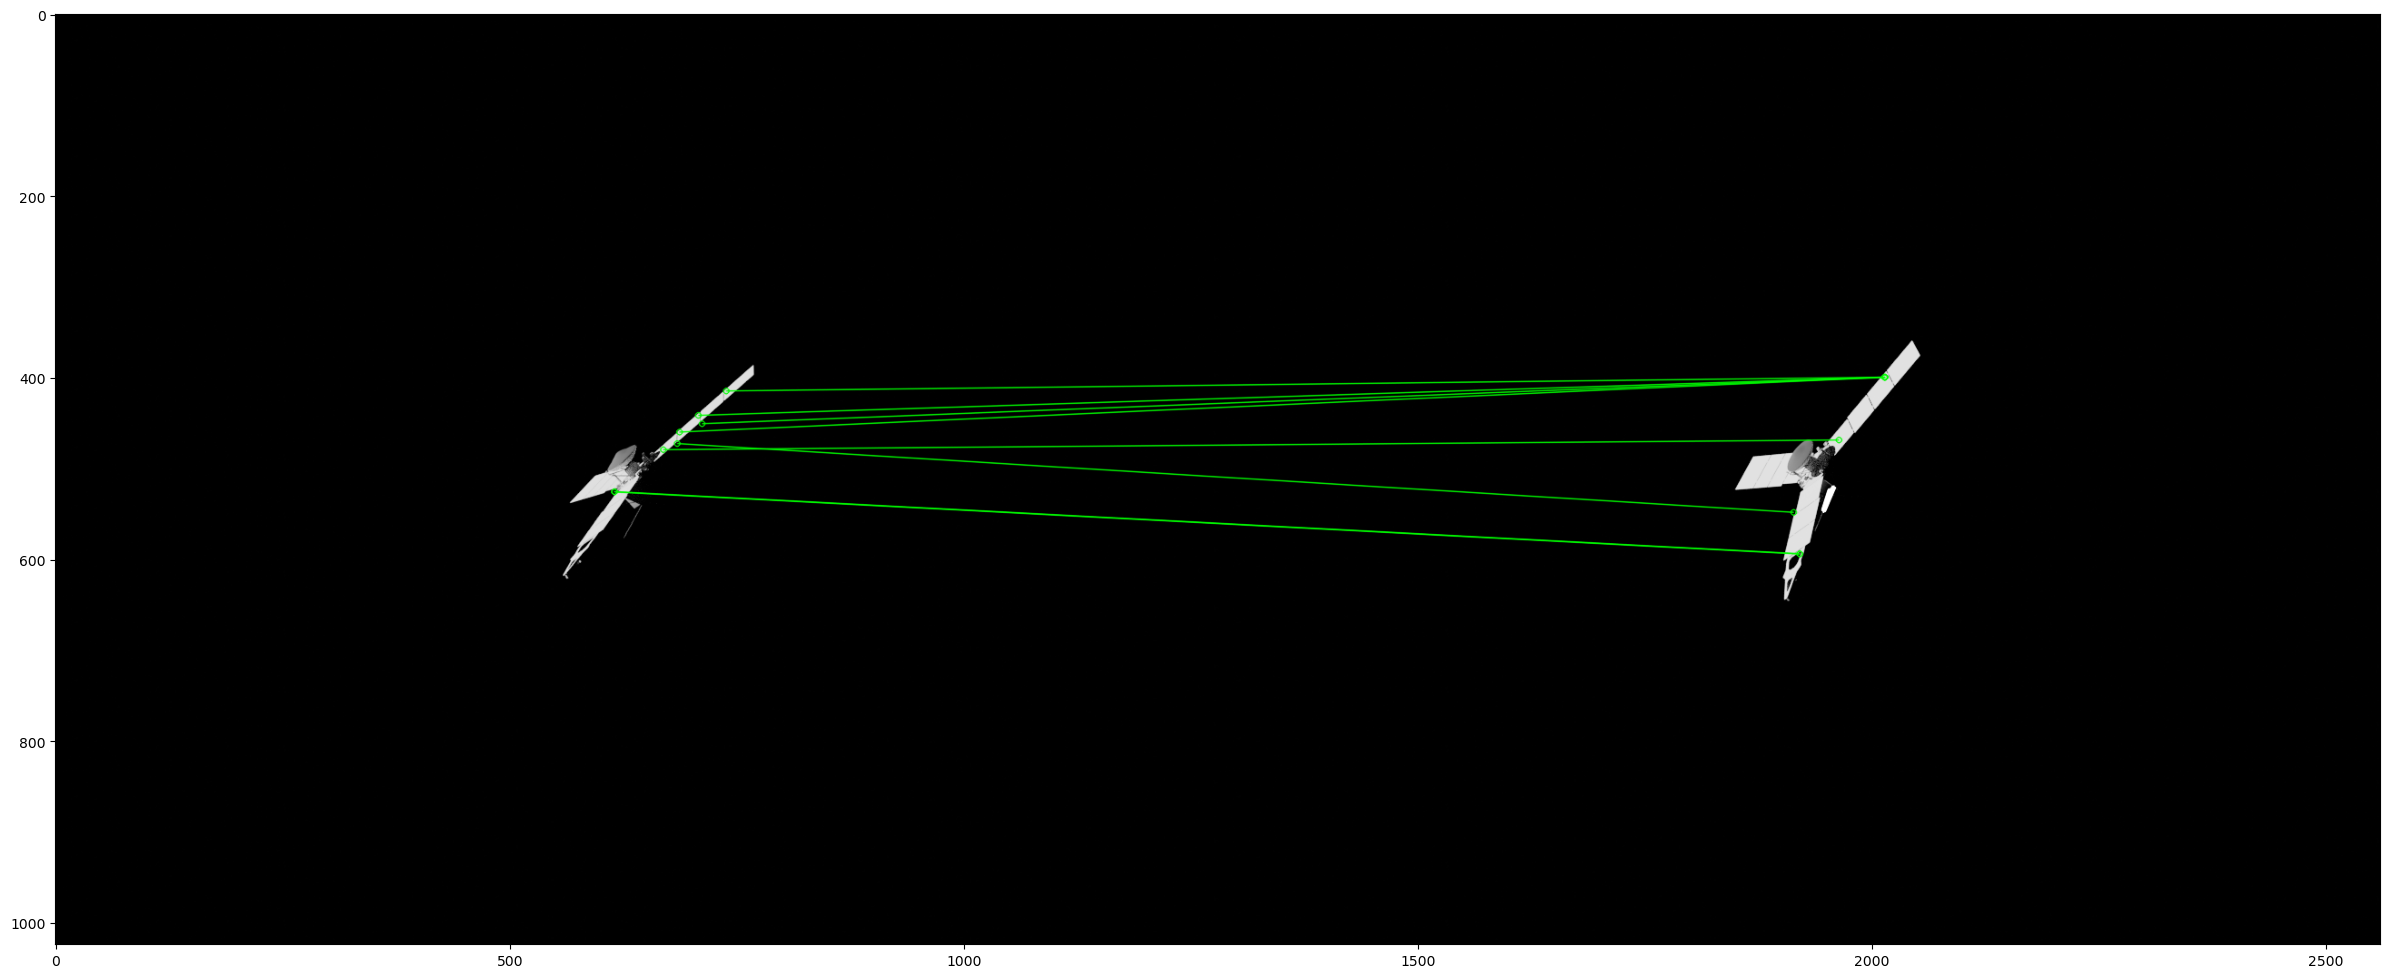

In [171]:
plt.figure(figsize=(30,30))
plt.imshow(imgMatch, 'gray')
plt.show()

In [1]:
# img_rgb = cv.cvtColor(cv.imread(img1path), cv.COLOR_BGR2RGB)
# cv.imshow('Image', img_rgb)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [33]:
def calculate_pose(homography_matrix):
    # Extract rotation and translation from homography matrix
    rot_matrix = np.zeros((3, 3))
    rot_matrix[:, :2] = homography_matrix[:, :2]
    rot_matrix[:, 2] = np.cross(rot_matrix[:, 0], rot_matrix[:, 1])
    translation = homography_matrix[:, 2] / np.linalg.norm(homography_matrix[:, :2])

    # Convert rotation matrix to quaternion
    trace = np.trace(rot_matrix)
    if trace > 0:
        s = 0.5 / np.sqrt(trace + 1.0)
        w = 0.25 / s
        x = (rot_matrix[2, 1] - rot_matrix[1, 2]) * s
        y = (rot_matrix[0, 2] - rot_matrix[2, 0]) * s
        z = (rot_matrix[1, 0] - rot_matrix[0, 1]) * s
    else:
        if rot_matrix[0, 0] > rot_matrix[1, 1] and rot_matrix[0, 0] > rot_matrix[2, 2]:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[0, 0] - rot_matrix[1, 1] - rot_matrix[2, 2])
            w = (rot_matrix[2, 1] - rot_matrix[1, 2]) / s
            x = 0.25 * s
            y = (rot_matrix[0, 1] + rot_matrix[1, 0]) / s
            z = (rot_matrix[0, 2] + rot_matrix[2, 0]) / s
        elif rot_matrix[1, 1] > rot_matrix[2, 2]:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[1, 1] - rot_matrix[0, 0] - rot_matrix[2, 2])
            w = (rot_matrix[0, 2] - rot_matrix[2, 0]) / s
            x = (rot_matrix[0, 1] + rot_matrix[1, 0]) / s
            y = 0.25 * s
            z = (rot_matrix[1, 2] + rot_matrix[2, 1]) / s
        else:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[2, 2] - rot_matrix[0, 0] - rot_matrix[1, 1])
            w = (rot_matrix[1, 0] - rot_matrix[0, 1]) / s
            x = (rot_matrix[0, 2] + rot_matrix[2, 0]) / s
            y = (rot_matrix[1, 2] + rot_matrix[2, 1]) / s
            z = 0.25 * s

    return translation, [x, y, z, w]


In [36]:
translation, quat = calculate_pose(M)

In [37]:
translation

array([620.71499515, 508.70476913,   0.92980055])

In [38]:
quat

[-0.00029664116316386924,
 -0.00031669406374587117,
 0.719521014529947,
 0.049691004139257325]

In [50]:
def move_image(image_path, pose):
    # Read the image
    image = cv.imread(image_path)
    
    # Extract translation and rotation from the pose
    translation = pose[:3]
    quaternion = pose[3:]
    
    # Convert quaternion to rotation matrix
    rotation = Rotation.from_quat(quaternion).as_matrix()
    
    # Apply translation
    translation_matrix = np.eye(4)
    translation_matrix[:3, 3] = translation
    # Apply rotation
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation
    
    # Apply transformation to image
    rows, cols, _ = image.shape
    new_image = cv.warpPerspective(image, transformation_matrix[:3], (cols, rows))
    
    return new_image

In [54]:
# Move the image
pose = [7.64022827,-46.98920059,-42.21747971,0.98997474,-0.0941886,-0.07856753,0.07003857]
# new_image = move_image(img1path, pose)

# # Show the original and moved image
# cv.imshow('Original Image', cv.imread(img1path))
# cv.imshow('Moved Image', new_image)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [113]:
image = cv.imread(img1path)
translation = np.float32(pose[:3])
quaternion = np.float32(pose[3:])
rotation = Rotation.from_quat(quaternion).as_matrix().astype(np.float32)

In [114]:
quaternion
print(type(quaternion))

<class 'numpy.ndarray'>


In [85]:
def quaternion_to_rotation_matrix(q):
    # Extract quaternion components
    qw, qx, qy, qz = q
    # Compute rotation matrix
    R = np.array([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
                  [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
                  [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]])
    return R

In [88]:
R = quaternion_to_rotation_matrix(quaternion)
transformation_matrix = np.identity(4)
transformation_matrix[:3, :3] = R
transformation_matrix[:3, 3] = translation

In [115]:
rotation.dtype

dtype('float32')

In [117]:
cv.perspectiveTransform(

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:2757: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'warpAffine'


In [97]:
transformation_matrix

array([[  0.97784348,  -0.1238725 ,  -0.16875341,   7.64022827],
       [  0.15347316,   0.97244621,   0.17548315, -46.98920059],
       [  0.14236607,  -0.19749418,   0.9699113 , -42.21747971],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [93]:
# Normalize transformation matrix
transformation_matrix = transformation_matrix / transformation_matrix[3, 3]

# Extract rotation and translation components
rotation_matrix = transformation_matrix[0:3, 0:3]
translation_vector = transformation_matrix[0:3, 3]

projection_matrix = np.hstack([rotation_matrix, translation_vector.reshape(3, 1)])

In [96]:
transformed_image = cv.warpPerspective(image, projection_matrix, (image.shape[1], image.shape[0]))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [91]:
transformed_image = cv.warpPerspective(image, transformation_matrix, (image.shape[1], image.shape[0]))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [65]:
# Combine translation and rotation into transformation matrix
transformation_matrix = np.eye(4)
transformation_matrix[:3, :3] = rotation
transformation_matrix[:3, 3] = translation

In [67]:
rows, cols, _ = image.shape

In [69]:
new_image = cv.warpPerspective(image, transformation_matrix[:3], (cols, rows))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'
